# Final Project for Financial Machine Learning, School of Finance, Soongsil University.

Main Contributor: Hyeonjun Kim (Idea Development, Financial Research, Programming), Kyumin Park (Presentation, Data Analysis), Sihyeon Soung (Peer Review)

## Project Overview

The goal of the project is using past financial statements and stock price data for predicting deviation from fundamental values. This makes possible for value investing and some risky arbitrage.

## Theory of the Project

If assuming that stock return at time $i$ ($R_p^{(i)}$) can be decomposed to 3 elements; expected return $R_E^{(i)}$, deviation from fundamental values $DF^{(i)}$, and information shock $IC^{(i)}$.

$R_p^{(i)}= R_E^{(i)}+DF^{(i)}+IC^{(i)}$

Where $IC^{(i)} \sim N(0, \sigma^2$, and $DF^{(i)}\sim 0, \sigma_{DF}^2$

If the deviation from fundamental values($DF^{(i)}$) is explained by a linear or nonlinear combination of variables $x_1^{(i)}, x_2^{(i)}, x_3^{(i)} \cdots x_n^{(i)}$, training the machine learning model by using $x_1^{(i)}, x_2^{(i)}, x_3^{(i)} \cdots x_n^{(i)}$ as featues and $R_p^{(i)}$ as target value will result in the model that output $\hat{R_p^{(i)}}$. Here we get the statistic $Diff^{(i)}=R_p^{(i)}-\hat{R_p^{(i)}}=DF^{(i)}+IC^{(i)}$.

The statistical structure of $Diff^{(i)}$ is as follows. As the variance of $DF^{(i)}$ is explained by  $x_1^{(i)}, x_2^{(i)}, x_3^{(i)} \cdots x_n^{(i)}$, $\sigma^2 <V[Diff^{(i)}] \ll \sigma^2 + \sigma_{DF}^2$, and $E[Diff^{(i)}] = 0$.
This means statistical signficance of z-statistic ${Diff^{(i)}-E[Diff^{(i)}] \over \sqrt{V[Diff^{(i)}]}}$ is able to test signficantly big absolute value of $DF^{(i)}$ and its sign.

## Trading Logic

By using a negative of z-statistic of n-month of $Diff^{(i)}$ as trading signal, we can long the under-valued stock and short the over-valued stock. This requires for local stationary feature of the  $Diff^{(i)}$. We can take only Long positions, as shorting the overvalued stock does not result in steady profit.

## Disclaimer

The data that been used were not availiable for the public because of user contract. This code only shows the outline of the project, and not made as stand-alone program. Of course you can use your custom data as the alternative.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Using Custom Module for reading DataGuide(Korean stock database) excel file. 
from fqtoolkit import dgToDf as dtd
import statsmodels.api as sm
from sklearn.metrics import classification_report

In [14]:
#You may use other machine learning algorithms. Using DT was arbitrary.

from sklearn.tree import DecisionTreeRegressor

In [15]:
#Making plots more clear.
%config InlineBackend.figure_format = "retina"

In [16]:
#Ignoring Warning
import warnings

warnings.filterwarnings("ignore")

In [17]:
#loading data
#You may use your country's stock price and f/s data. 

assets, liability, sale, income, price = [item[1] for item in dtd("data2.xlsx", "Sheet1", 5).items()]

In [18]:
def betaMinus(array): #function for calculating residual of CAPM
    
    x= price.iloc[132::12, :].pct_change().mean(axis=1)
    
    y = array.copy()
    
    temp = pd.DataFrame({"x":x, "y":y}).dropna()
    
    return y - (temp.corr().iloc[0, 1] * y.std() / x.std()) * x

In [19]:
#Calculating asset growth and liability growth.

assets0 = assets.pct_change()

liability0 = liability.pct_change()

In [20]:
#fill the missing values by forward fill.

assets0 = assets0.where(assets0 != 0, np.nan).fillna(method="ffill")

liability0 = liability0.where(liability0 != 0, np.nan).fillna(method="ffill")

In [21]:
#Using shift, we delay the data so that data leakage is impossible.

assets0 = assets0.shift(12+6)
liability0 = liability0.shift(12+6)
sale = sale.shift(12+6)
income = income.shift(12+6)

In [22]:
sale.head(30)

,삼성전자,LG에너지솔루션,SK하이닉스,삼성바이오로직스,NAVER,삼성SDI,현대차,카카오,LG화학,기아,...,네이처셀,주성엔지니어링,SFA반도체,덕산네오룩스,메가스터디교육,NICE평가정보,피엔티,케어젠,와이지엔터테인먼트,에이비엘바이오
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2000-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
returns = price.pct_change()

In [24]:
#price = price.dropna(axis=1)
returns = price.shift(0).pct_change()
returns0 = price.shift(0).pct_change()
returns.head(20)

,삼성전자,LG에너지솔루션,SK하이닉스,삼성바이오로직스,NAVER,삼성SDI,현대차,카카오,LG화학,기아,...,네이처셀,주성엔지니어링,SFA반도체,덕산네오룩스,메가스터디교육,NICE평가정보,피엔티,케어젠,와이지엔터테인먼트,에이비엘바이오
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2000-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-29,-0.082353,NaN,-0.321969,NaN,NaN,-0.260679,-0.295339,0.514400,NaN,-0.334669,...,0.519904,0.274816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03-31,0.308528,NaN,0.374299,NaN,NaN,0.246199,0.112115,-0.442917,NaN,0.118542,...,0.684271,-0.244460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04-30,-0.104579,NaN,-0.284553,NaN,NaN,0.129266,-0.220115,-0.487833,NaN,0.007934,...,-0.078178,-0.087366,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05-31,0.026641,NaN,0.000000,NaN,NaN,-0.071280,0.157807,0.535240,NaN,0.226033,...,-0.357586,-0.283624,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-06-30,0.199722,NaN,0.250001,NaN,NaN,0.255939,0.181818,0.315195,NaN,0.035772,...,0.266484,0.054159,NaN,NaN,NaN,-0.246512,NaN,NaN,NaN,NaN
2000-07-31,-0.200463,NaN,-0.209091,NaN,NaN,-0.078515,0.045470,-0.326419,NaN,0.124862,...,-0.406243,-0.457172,NaN,NaN,NaN,0.272840,NaN,NaN,NaN,NaN
2000-08-31,-0.072947,NaN,0.166668,NaN,NaN,0.004074,0.123720,-0.030795,NaN,-0.062389,...,0.449156,-0.094646,NaN,NaN,NaN,-0.270611,NaN,NaN,NaN,NaN
2000-09-30,-0.261334,NaN,-0.214286,NaN,NaN,-0.109097,-0.136872,-0.158951,NaN,-0.096348,...,-0.268767,-0.417404,NaN,NaN,NaN,-0.174202,NaN,NaN,NaN,NaN


In [30]:

# Searching for optimal max depth of the decision tree model.


r2 = []

for maxD in range(1,10):
    
    results = {}

    for col in returns.columns: #loop though every possible stock

        reSeries = {}
        
    

        for n in range(1, returns.shape[0]-152): #loop through time for the walk-forward validation

            #preparing the rolling data for each stock
            temp = pd.DataFrame({"asset":assets0[col].iloc[n:n+151], #asset change
                                "liability":liability0[col].iloc[n:n+151], #liability change
                                "sale":sale[col].iloc[n:n+151], #sales
                                 "income":income[col].iloc[n:n+151], #income
                                 "re0": returns[col].iloc[n-1:n+150], #past return
                                "re": returns[col].iloc[n:n+151]}) #current return

            temp = temp.dropna() # deleting rows with nan values 


            if temp.shape[0] < 50: #if the data have less than 50 observations, the signal is not generated.

                continue

            model = DecisionTreeRegressor(max_depth=maxD, random_state=10) #model initialization

            model.fit(temp.drop("re", axis=1).iloc[:-1,:], temp["re"].iloc[:-1]) #current return estimating model fitting

            r = model.predict(temp.drop("re", axis=1).iloc[[-1], :]) #get the in-sample prediction.

            reSeries[temp.index[-1]] = temp["re"].iloc[-1]-r[0] #calculate the current estimation error, or diff
            if len(reSeries) > 0:
                results[col] = pd.Series(reSeries)
    
    results = pd.DataFrame(results)
                
    signal = (results).mean(axis=1) #get the simple mean signal for every stocks

    temp = pd.DataFrame({"returns":returns.shift(-1).mean(axis=1), "result":signal}).dropna() #preparing the data for performance test. signal and out-of-sample return.
    test = temp.iloc[int(temp.shape[0]/4):2*int(temp.shape[0]/4), :] #validation set
    test0 = temp.iloc[2*int(temp.shape[0]/4):, :] #test set

    mu = temp.result.iloc[:int(temp.shape[0]/4)].mean() #average of the signal in training set
    sd = temp.result.iloc[:int(temp.shape[0]/4)].std() #standard deviation of the signal in training set

    test.result = (test.result-mu)/sd #standardization of validation set signal

    test0.result = (test0.result-mu)/sd #standardization of test set signal

    r2.append(np.corrcoef(test.returns, -test.result)[1,0 ] ** 2 ) #calculate the validation set r-squared between next month return and validation set signal

    print(f"R-Square {np.corrcoef(test.returns, -test.result)[1,0 ] ** 2 * 100:.4f}% at max depth {maxD}")



R-Square 0.8662% at max depth 1
R-Square 0.0736% at max depth 2
R-Square 5.8728% at max depth 3
R-Square 31.5541% at max depth 4
R-Square 20.1392% at max depth 5
R-Square 17.5281% at max depth 6
R-Square 11.5188% at max depth 7
R-Square 5.9206% at max depth 8
R-Square 4.0131% at max depth 9


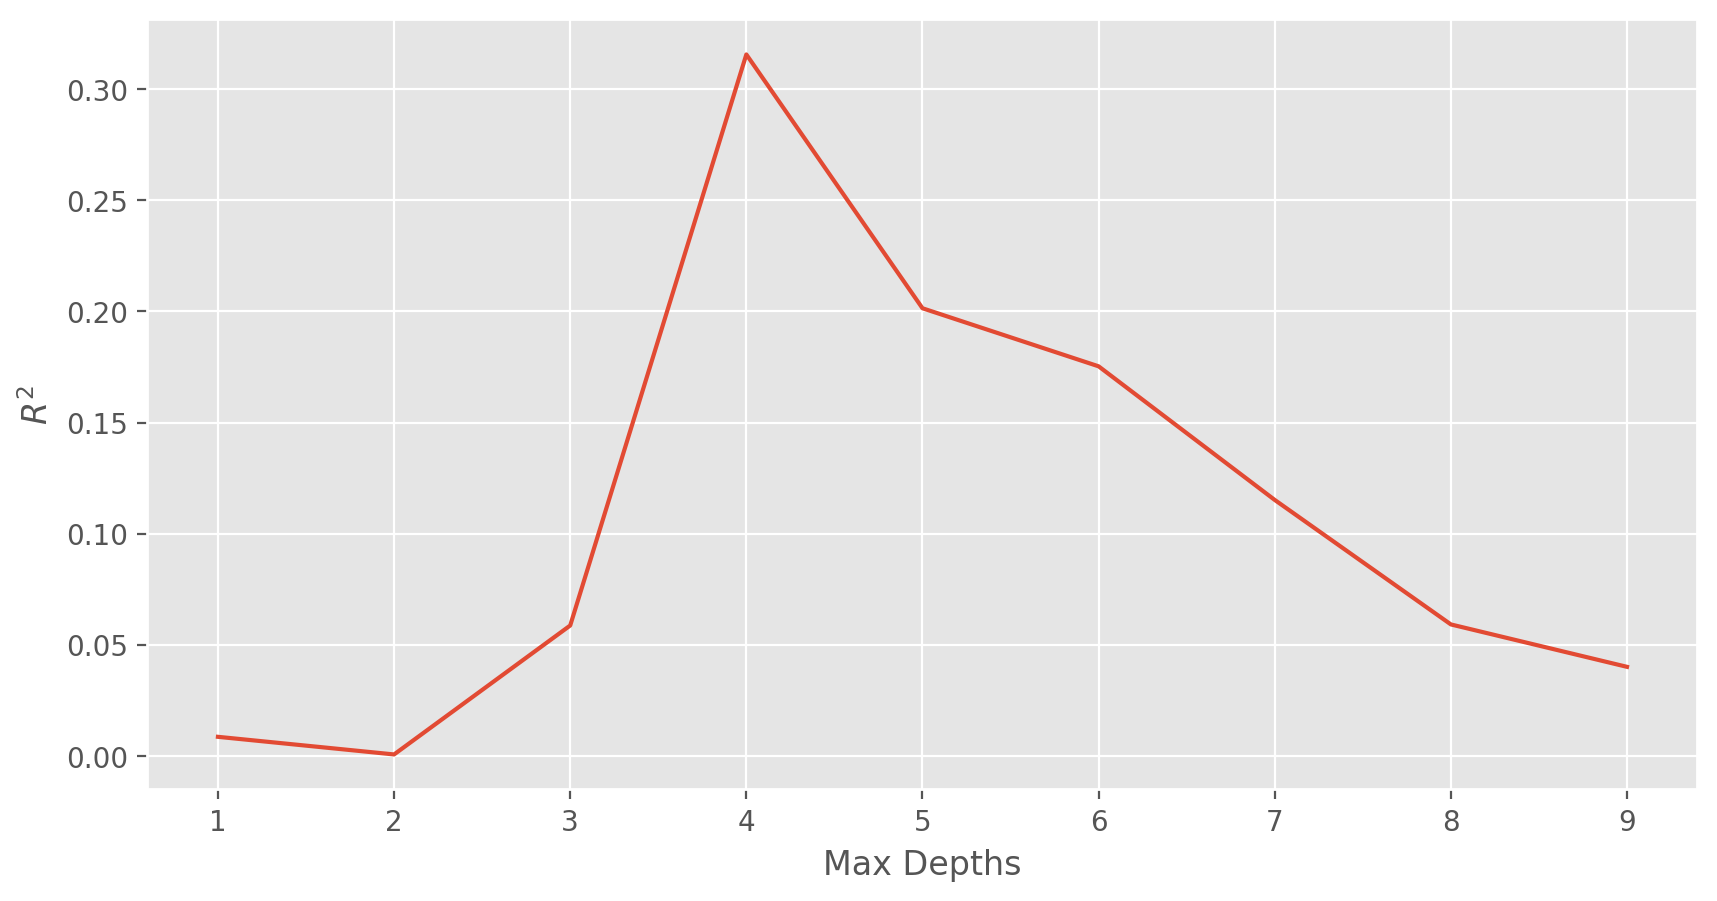

In [31]:
#Visualization
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.xlabel("Max Depths")
plt.ylabel("$R^2$")
plt.plot(list(range(1, 10)), r2)

### Choose the hyperparamter according to validation set results and input the optimal max depth at the maxD variable below.

The code below is almost identical to the upper one, with slight differences. For example, this time we specify the max depth.

In [32]:
maxD = 4
results = {}

for col in returns.columns:

    reSeries = {}

    for n in range(1, returns.shape[0]-152):

            #n부터 n+120까지의 롤링 데이터 준비
        temp = pd.DataFrame({"asset":assets0[col].iloc[n:n+151],
                                "liability":liability0[col].iloc[n:n+151],
                                "sale":sale[col].iloc[n:n+151],
                                "income":income[col].iloc[n:n+151],
                                 "re0": returns[col].iloc[n-1:n+150],
                                "re": returns[col].iloc[n:n+151]})

        temp = temp.dropna()


        if temp.shape[0] < 50:

            continue

        model = DecisionTreeRegressor(max_depth=maxD, random_state=10)#

        model.fit(temp.drop("re", axis=1).iloc[:-1,:], temp["re"].iloc[:-1])

        r = model.predict(temp.drop("re", axis=1).iloc[[-1], :])

        reSeries[temp.index[-1]] = temp["re"].iloc[-1]-r[0]

        if len(reSeries) > 0:
            results[col] = pd.Series(reSeries)





In [33]:
from sklearn.metrics import confusion_matrix

In [34]:
#Confusion matrix and R-Squared for test data

results = pd.DataFrame(results)


signal = (results).mean(axis=1)

temp = pd.DataFrame({"returns":returns.shift(-1).mean(axis=1), "result":signal}).dropna() 
test = temp.iloc[int(temp.shape[0]/4):2*int(temp.shape[0]/4), :] 
test0 = temp.iloc[2*int(temp.shape[0]/4):, :] 


mu = temp.result.iloc[:int(temp.shape[0]/4)].mean() 
sd = temp.result.iloc[:int(temp.shape[0]/4)].std()


test.result = (test.result-mu)/sd

test0.result = (test0.result-mu)/sd
# making the signals where 
test["port"] = test["returns"]* np.where( test.result< 0,-test.result**2, 0) # 
test0["port"] = test0["returns"] * np.where( test0.result< 0,-test0.result**2, 0) 

print("Test set Result")
print(f"{np.corrcoef(test0.returns, -test0.result)[1,0 ] ** 2 * 100:.4f}%")
print("Confusion Matrix")
print(confusion_matrix(np.where(test0.returns> 0, 1, 0), np.where(-test0.result >0, 1, 0)))


Test set Result
0.2829%
Confusion Matrix
[[ 9  9]
 [18 22]]


## Applying Strategy on Individual Stock

Untill now, we focused on the market overall performance of the signal(the market average). This time, we will apply strategy for each stock and average the performance.

In [35]:
tVals = []

ports = {} #

for col in results.columns:
    
    #종목별로 위의 과정을 거침
    
    temp = pd.DataFrame({"returns":returns.shift(-1)[col], "result":results[col]}).dropna()
    test = temp.iloc[int(temp.shape[0]/4):2*int(temp.shape[0]/4), :]
    test0 = temp.iloc[2*int(temp.shape[0]/4):, :]

    mu = temp.result.iloc[:int(temp.shape[0]/4)].mean()
    sd = temp.result.iloc[:int(temp.shape[0]/4)].std()

    test.result = (test.result-mu)/sd

    test0.result = (test0.result-mu)/sd


    test["port"] = test["returns"]* np.where( test.result< 0, -test.result, 0)#
    test0["port"] = test0["returns"] * np.where( test0.result< 0, -test0.result, 0)
    
    ports[col] = test0["port"] #종목별 전략 성과 저장

    

In [36]:
ports = pd.DataFrame(ports)

ports.head()

,삼성전자,SK하이닉스,삼성바이오로직스,NAVER,삼성SDI,현대차,카카오,LG화학,기아,POSCO홀딩스,...,안랩,네이처셀,주성엔지니어링,SFA반도체,덕산네오룩스,메가스터디교육,NICE평가정보,피엔티,케어젠,와이지엔터테인먼트
2017-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-31,0.000000,0.000000,NaN,-0.009106,0.000000,-0.014558,0.000000,-0.037660,-0.000000,0.000000,...,-0.059333,0.0,0.000000,0.000000,NaN,NaN,-0.006435,NaN,NaN,NaN
2017-06-30,0.001232,-0.000000,NaN,-0.049605,-0.018235,-0.000000,0.000000,0.000000,-0.042778,0.000000,...,0.030651,0.0,0.000000,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN
2017-07-31,-0.074570,0.000000,NaN,-0.089918,0.067247,-0.000000,0.029069,0.256015,-0.015373,0.041242,...,-0.000000,0.0,0.000000,-0.216664,NaN,NaN,-0.000000,NaN,NaN,NaN
2017-08-31,0.000133,0.093178,NaN,-0.009595,0.019976,0.013965,0.000000,0.036032,-0.000000,-0.007592,...,-0.000000,-0.0,-0.086918,-0.002989,NaN,NaN,0.027371,NaN,NaN,NaN


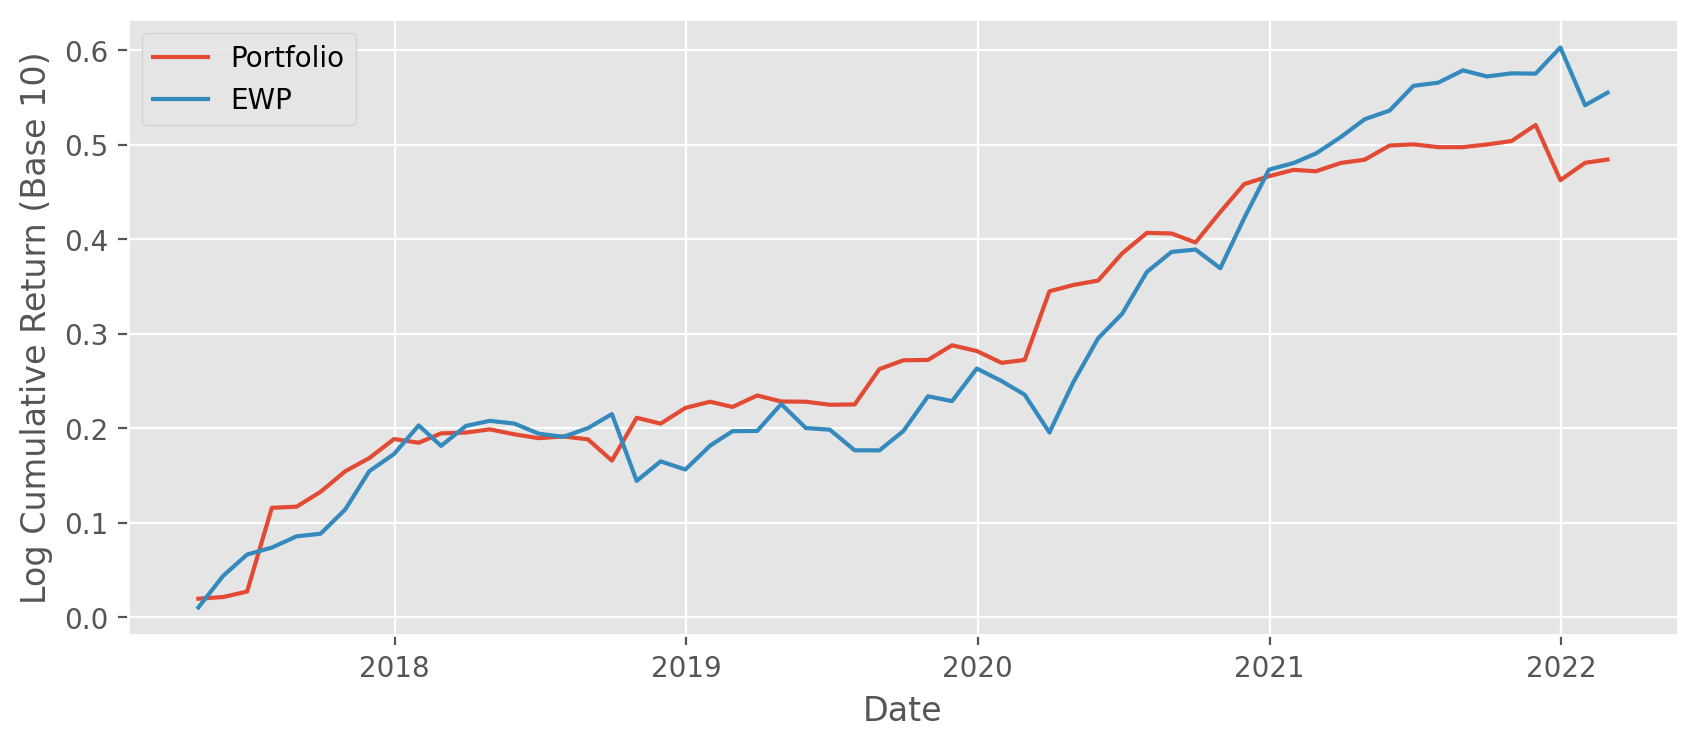

In [37]:
#Visualling the backtesting result
plt.style.use("ggplot")
plt.figure(figsize=(10, 4))
plt.xlabel("Date")
plt.ylabel("Log Cumulative Return (Base 10)")
plt.plot(np.log10((1+ports.mean(axis=1)).cumprod()), label="Portfolio")
plt.plot(np.log10((1+returns.loc[ports.index, :].mean(axis=1)).cumprod()), label="EWP")
plt.legend()

In [38]:
#Report essential statistics

P = ports.mean(axis=1)[:]
EWP = returns.loc[ports.index, :].mean(axis=1)[:]



result = {"Portfolio":[P.mean(), P.std(), P.mean()/P.std(), np.percentile(P, 5)], 
          "EWP":[EWP.mean(), EWP.std(), EWP.mean()/EWP.std(), np.percentile(EWP, 5)]}


result= pd.DataFrame(result).T


result.columns = ["Mean", "SD", "Sharpe Ratio", "5 Percentile"]

result.iloc[:, [0,1 ,3]] = (np.round(result.iloc[:, [0,1 ,3]]*100, 2)).astype(str) + "%"

result["Sharpe Ratio"] = np.round(result["Sharpe Ratio"], 2)

result

,Mean,SD,Sharpe Ratio,5 Percentile
Portfolio,2.02%,4.93%,0.41,-2.23%
EWP,2.35%,5.7%,0.41,-6.0%


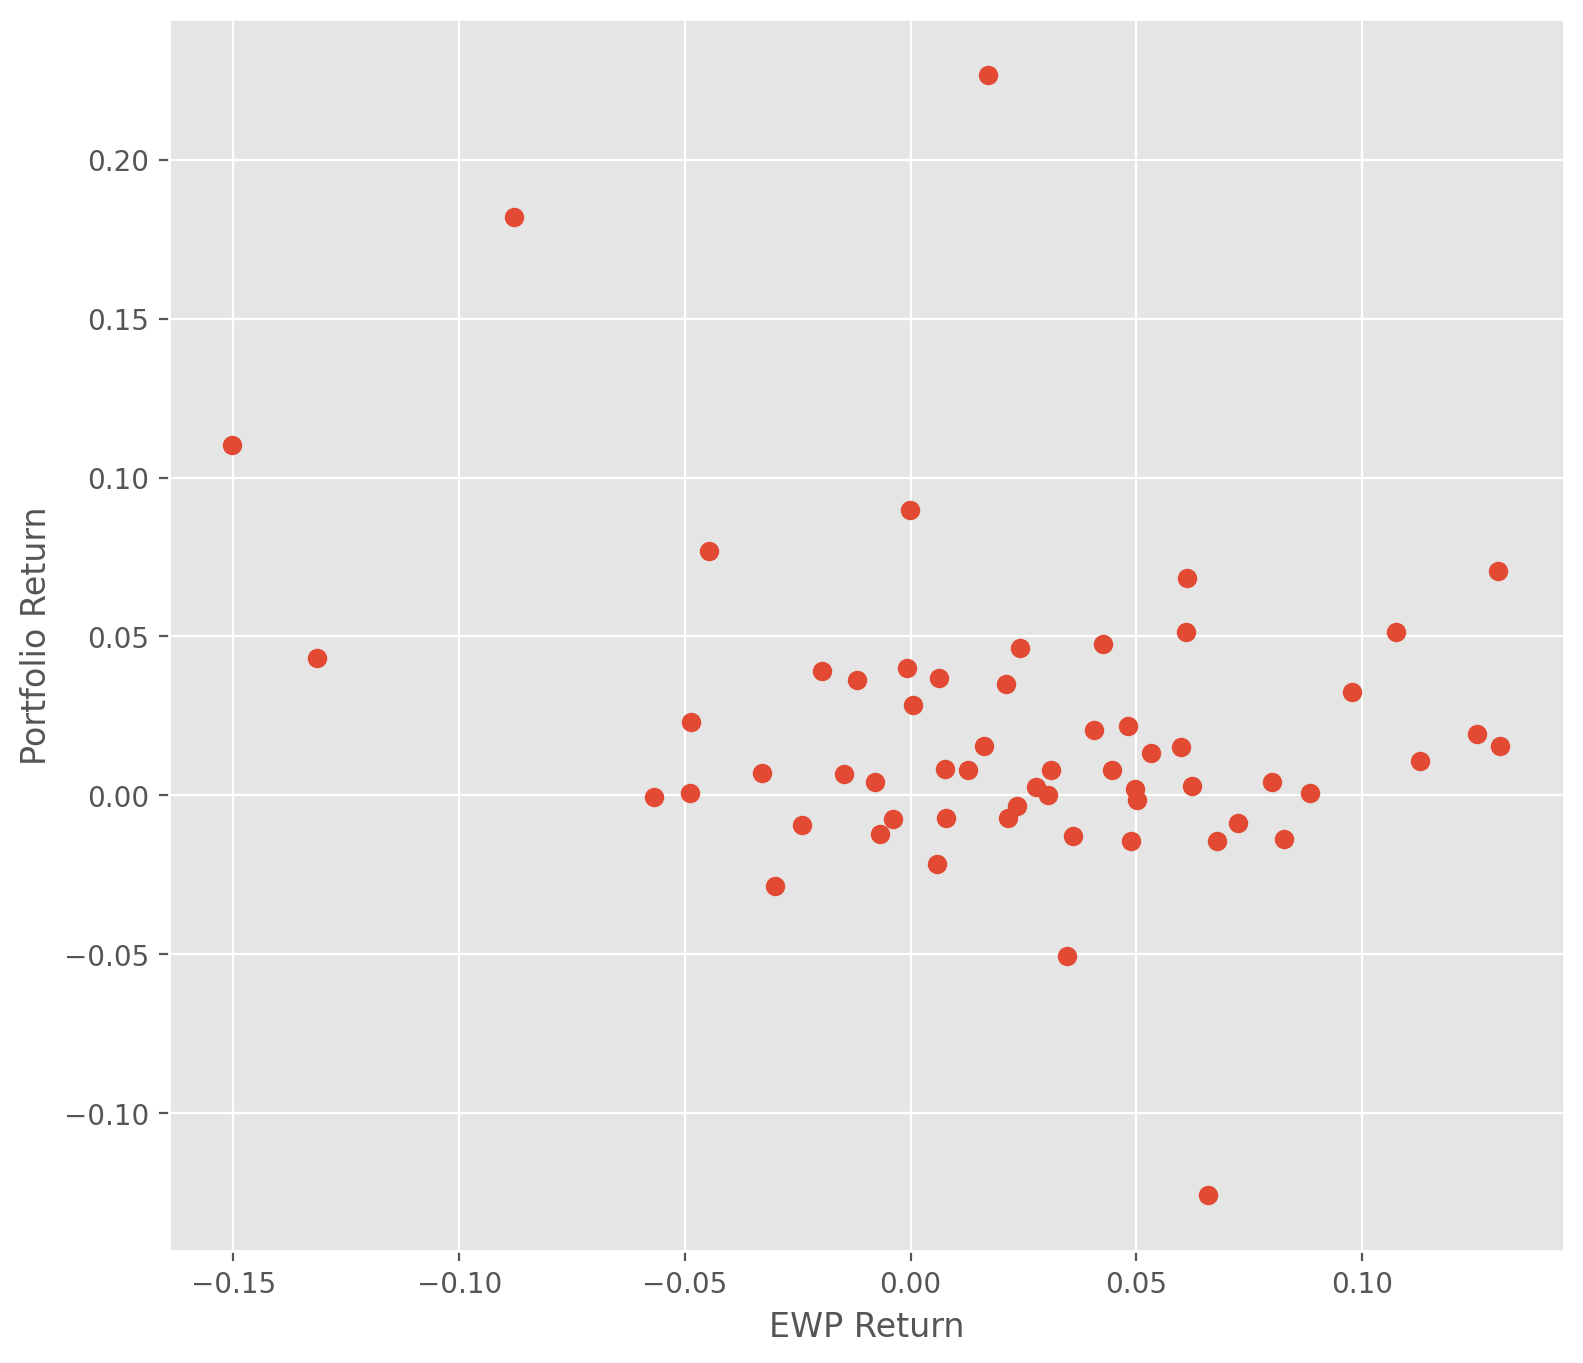

In [39]:
#EWP vs Portfolio return scatterplot

plt.figure(figsize=(9, 8))
plt.xlabel("EWP Return")
plt.ylabel("Portfolio Return")
plt.plot(returns.loc[ports.index, :].mean(axis=1), ports.mean(axis=1), "o")

## Nonparametric Test for Market Timing.

This method is based on the paper of Jiang(2003).

In [40]:
from itertools import combinations as c

def estimation(bench, port):
    
    n0 = 0
    
    n = 0
    
    for t1, t2, t3 in c(range(len(bench)), 3):
        
        n0 += 1
        
        rms = bench.iloc[[t1, t2, t3]].sort_values()
        
        trueT1, trueT2, trueT3 = rms.index
        
        betaH = (port.loc[trueT3] - port.loc[trueT2]) / (bench.loc[trueT3] - bench.loc[trueT2])
        
        betaL = (port.loc[trueT2] - port.loc[trueT1]) / (bench.loc[trueT2] - bench.loc[trueT1])
        
        if betaH > betaL:
            
            n += 1
            
            
    return 2*(n / n0) -1
        
    
def kernel(rms, ris):
    
    rm1, rm2, rm3 = rms
    ri1, ri2, ri3 = ris
    
    premise = rm1 < rm2 and rm2 < rm3
    
    if not premise:
        
        return 0
    
    betaH = (ri3 - ri2) / (rm3 - rm2)
        
    betaL = (ri2 - ri1) / (rm2 - rm1)
    
    conclusion = betaH > betaL
    
    
    if  premise and not conclusion:
        
        return 0
    
    else:
        
        return 1
    
    
    
def stanardE(bench, port, esti):
    
    sum0 = 0
    
    for t1 in bench.index:
        
        sum1 = 0
        
        n0 = 0
        
        for t2, t3 in c(bench.index, 2):
            
            n0 += 1
            
            sum1 += kernel(bench.loc[[t1, t2, t3]], port.loc[[t1, t2, t3]])
            
            
        sum1 = (sum1 / n0 - esti) ** 2
        
        sum0 += sum1
        
        
    
    var = 9 / len(bench.index) * sum0
    
    return np.sqrt(var)
    
from scipy.stats import norm

def nonParaMT(bench, port):
    
    esti = estimation(bench, port)
    se = stanardE(bench, port, esti)
    
    statistic = esti * np.sqrt(len(bench)) /se
    
    pVal = 1 - norm.cdf(statistic, loc=0, scale=1)
    
    return esti, se , statistic, pVal

In [42]:
result = nonParaMT(returns.loc[ports.index, :].mean(axis=1), ports.mean(axis=1))

In [43]:
print(f"P-value for the null hypothesis(non-convexity) is {result[-1]}")

P-value for the null hypothesis(non-convexity) is 0.00041172136062050946
